# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [5]:
file_path = r"C:\Users\ADMIN\Desktop\Delivery Starter Assignment\porter_data_1.csv"
df = pd.read_csv(file_path)

## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [7]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

df[['created_at', 'actual_delivery_time']].dtypes

created_at              datetime64[ns]
actual_delivery_time    datetime64[ns]
dtype: object

##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [9]:
categorical_cols = df.select_dtypes(include='object').columns

for col in categorical_cols:
    df[col] = df[col].astype('category')

df[categorical_cols].dtypes


Series([], dtype: object)

#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [11]:
df['time_taken'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 3600
df[['created_at', 'actual_delivery_time', 'time_taken']].head()

created_at actual_delivery_time  time_taken
0 2015-02-06 22:24:17  2015-02-06 23:11:17    0.783333
1 2015-02-10 21:49:25  2015-02-10 22:33:25    0.733333
2 2015-02-16 00:11:35  2015-02-16 01:06:35    0.916667
3 2015-02-12 03:36:46  2015-02-12 04:35:46    0.983333
4 2015-01-27 02:12:36  2015-01-27 02:58:36    0.766667

##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [13]:
df['order_hour'] = df['created_at'].dt.hour
df['order_day_of_week'] = df['created_at'].dt.day_name()

df['isWeekend'] = df['order_day_of_week'].isin(['Saturday', 'Sunday'])

df['isWeekend'] = df['isWeekend'].map({True: 'Weekend', False: 'Weekday'})

df[['created_at', 'order_hour', 'order_day_of_week', 'isWeekend']].head()

created_at  order_hour order_day_of_week isWeekend
0 2015-02-06 22:24:17          22            Friday   Weekday
1 2015-02-10 21:49:25          21           Tuesday   Weekday
2 2015-02-16 00:11:35           0            Monday   Weekday
3 2015-02-12 03:36:46           3          Thursday   Weekday
4 2015-01-27 02:12:36           2           Tuesday   Weekday

In [15]:
df.drop(['created_at', 'actual_delivery_time'], axis=1, inplace=True)
df.head()


market_id  store_primary_category  order_protocol  total_items  subtotal  \
0        1.0                       4             1.0            4      3441   
1        2.0                      46             2.0            1      1900   
2        2.0                      36             3.0            4      4771   
3        1.0                      38             1.0            1      1525   
4        1.0                      38             1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   3             820            1604                    8.0   
3                   1            1525            1525                    5.0   
4                   2            1425            2195                    5.0   

   total_busy_dashers  total_outstanding_orders  distance  time_taken  \
0                14.0                      21.0     34.44    0.783333   
1                 2.0                       2.0     27.60    0.733333   
2                 6.0                      18.0     11.56    0.916667   
3                 6.0                       8.0     31.80    0.983333   
4                 5.0                       7.0      8.20    0.766667   

   order_hour order_day_of_week isWeekend  
0          22            Friday   Weekday  
1          21           Tuesday   Weekday  
2           0            Monday   Weekday  
3           3          Thursday   Weekday  
4           2           Tuesday   Weekday

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [19]:
y = df['time_taken']

X = df.drop('time_taken', axis=1)

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (175777, 15)
Target shape: (175777,)


##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (140621, 15)
X_test shape: (35156, 15)
y_train shape: (140621,)
y_test shape: (35156,)


## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [25]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

if 'time_taken' in numerical_cols:
    numerical_cols.remove('time_taken')

print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)

Categorical columns: ['order_day_of_week', 'isWeekend']
Numerical columns: ['market_id', 'store_primary_category', 'order_protocol', 'total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance']


##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

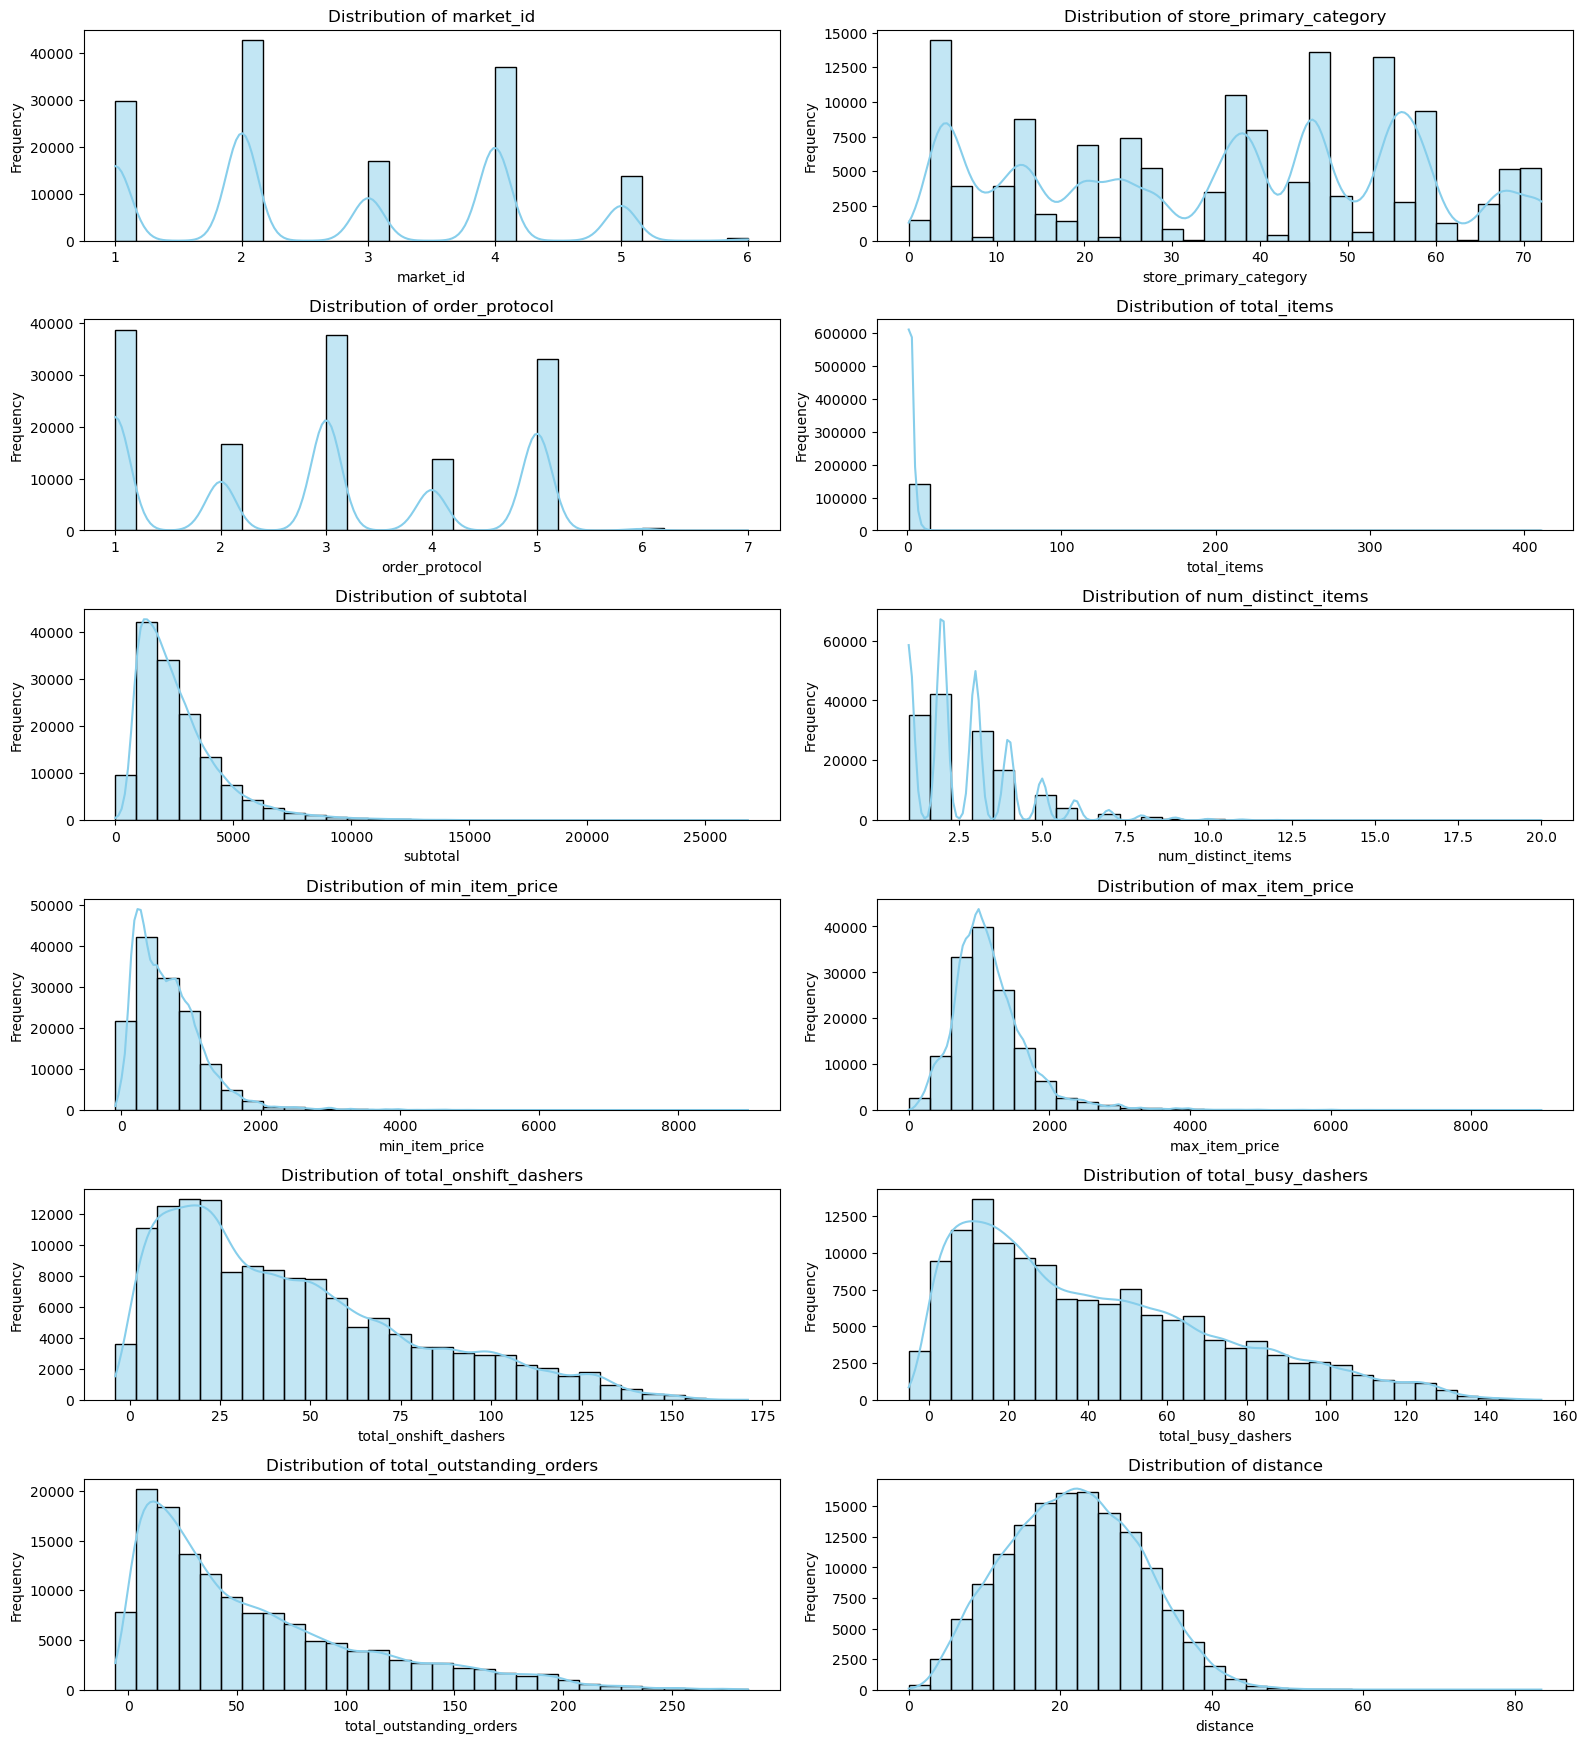

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

plt.figure(figsize=(16, 20))
for i, col in enumerate(numerical_cols):
    plt.subplot(len(numerical_cols) // 2 + 1, 2, i + 1)
    sns.histplot(X_train[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

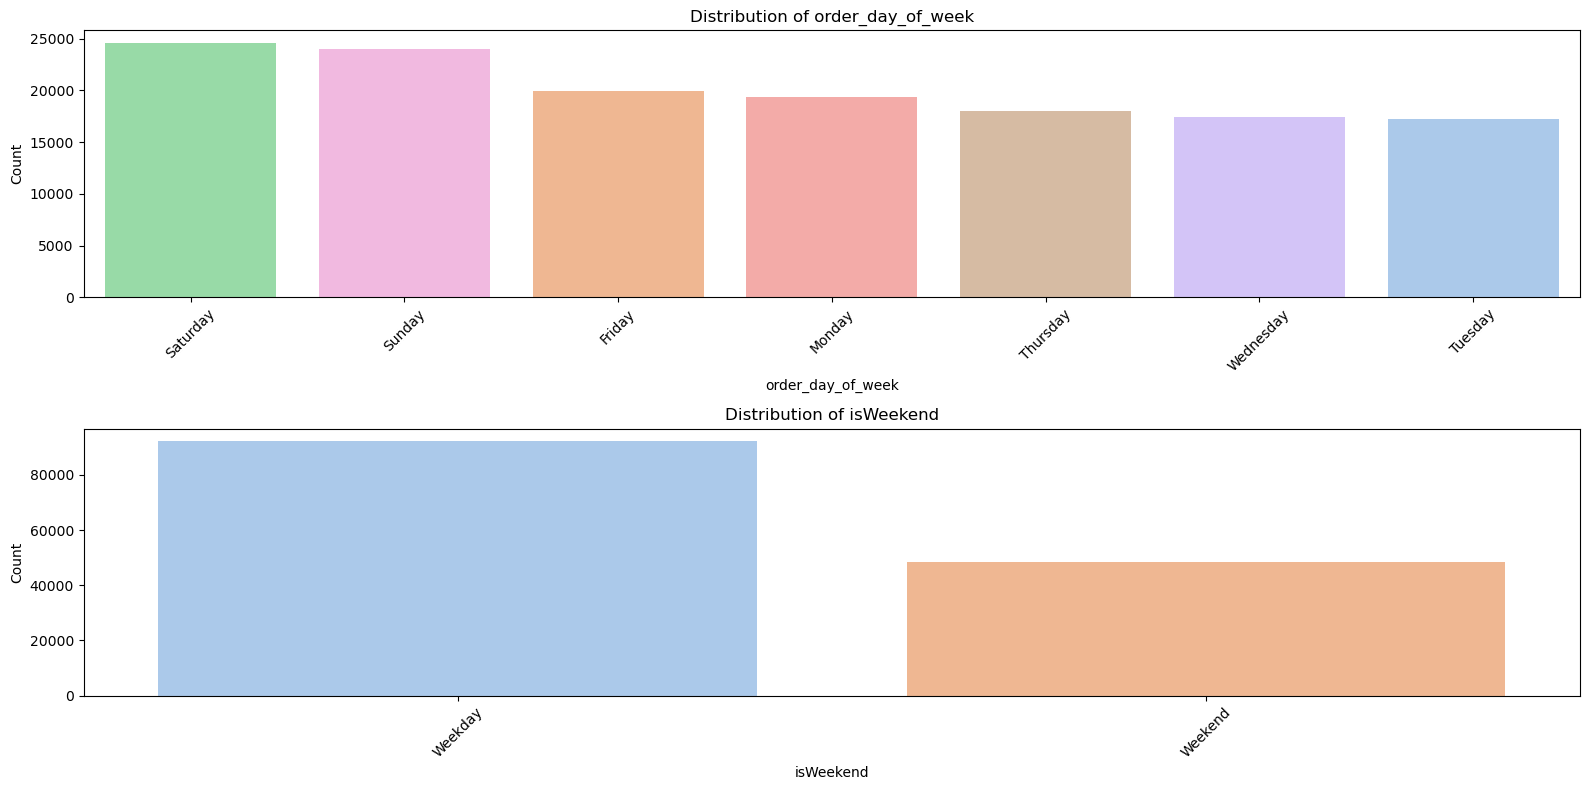

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

categorical_cols = X_train.select_dtypes(include='object').columns.tolist()

plt.figure(figsize=(16, len(categorical_cols) * 4))

for i, col in enumerate(categorical_cols):
    plt.subplot(len(categorical_cols), 1, i + 1)
    sns.countplot(data=X_train, x=col, hue=col, palette='pastel', order=X_train[col].value_counts().index, legend=False)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

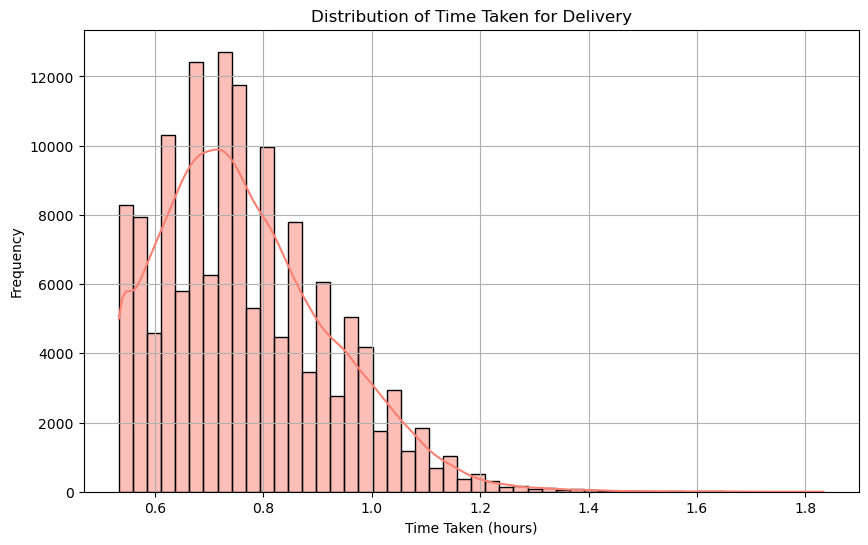

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(y_train, kde=True, bins=50, color='salmon')
plt.title('Distribution of Time Taken for Delivery')
plt.xlabel('Time Taken (hours)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

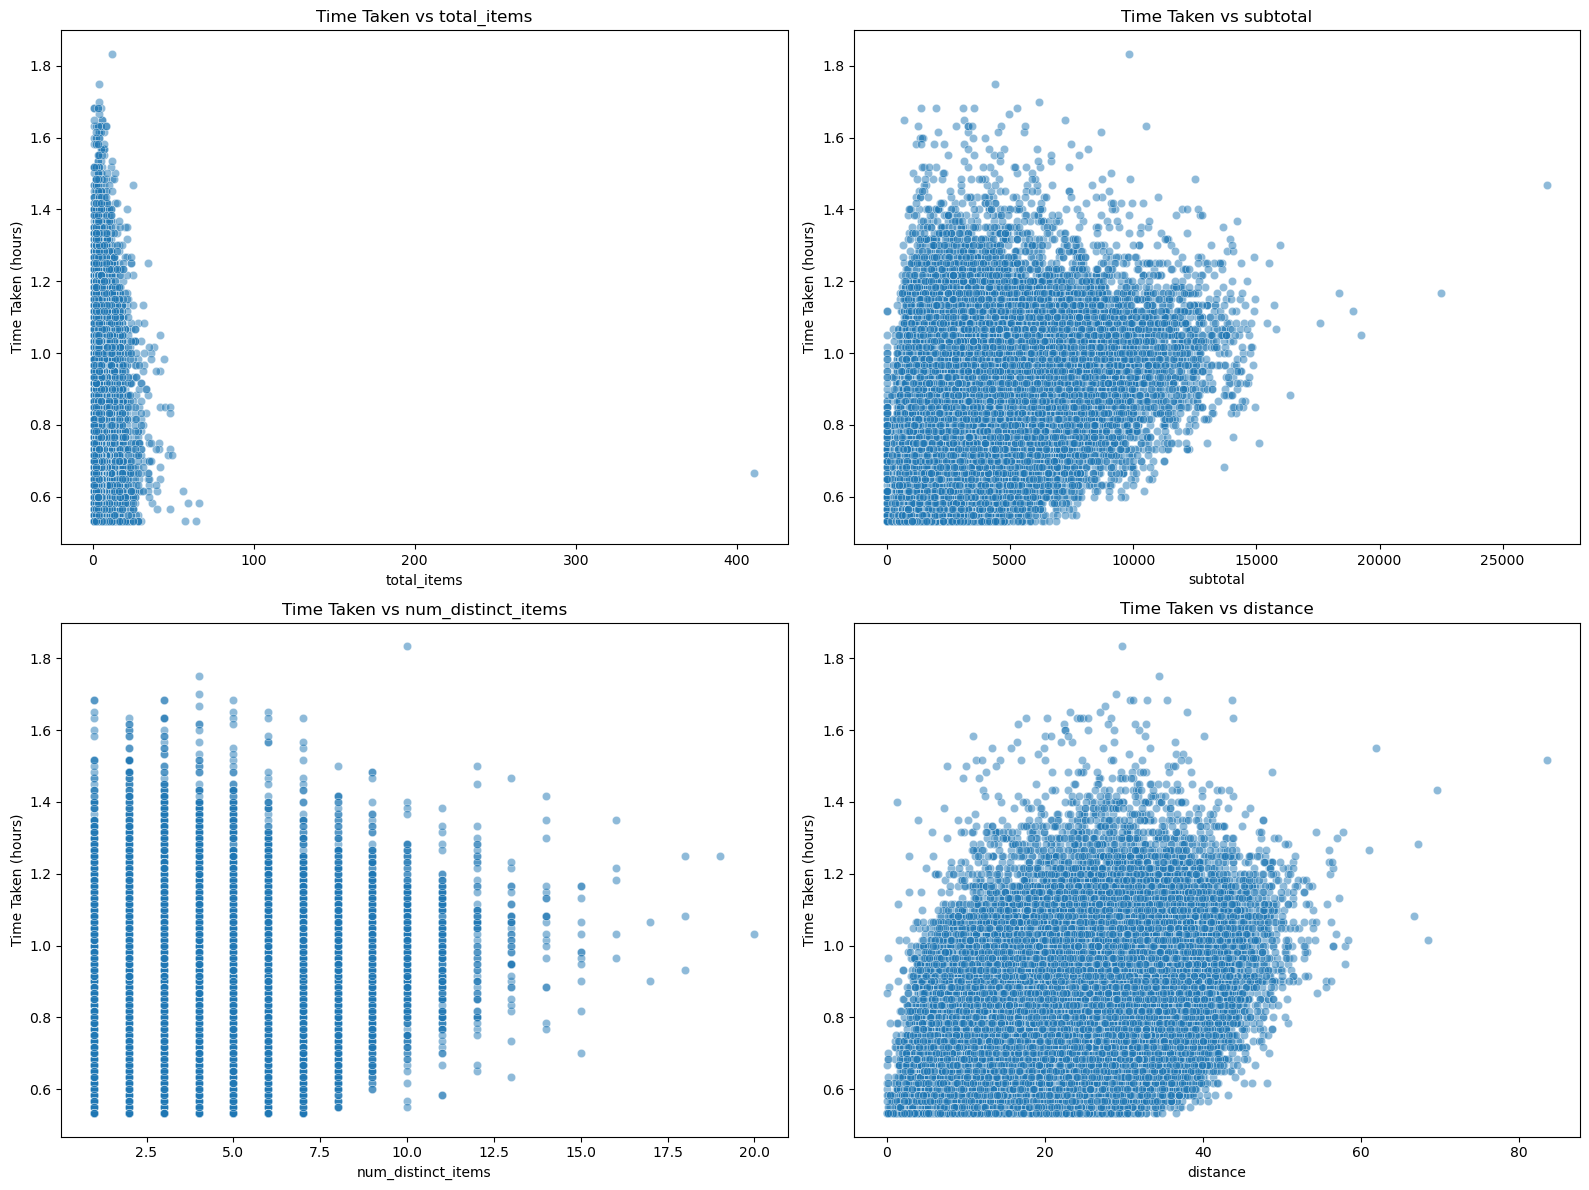

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pick a few important numerical features
important_numerical = ['total_items', 'subtotal', 'num_distinct_items', 'distance']

# Set up plot grid
plt.figure(figsize=(16, 12))
for i, col in enumerate(important_numerical):
    plt.subplot(2, 2, i + 1)
    sns.scatterplot(x=X_train[col], y=y_train, alpha=0.5)
    plt.title(f'Time Taken vs {col}')
    plt.xlabel(col)
    plt.ylabel('Time Taken (hours)')

plt.tight_layout()
plt.show()

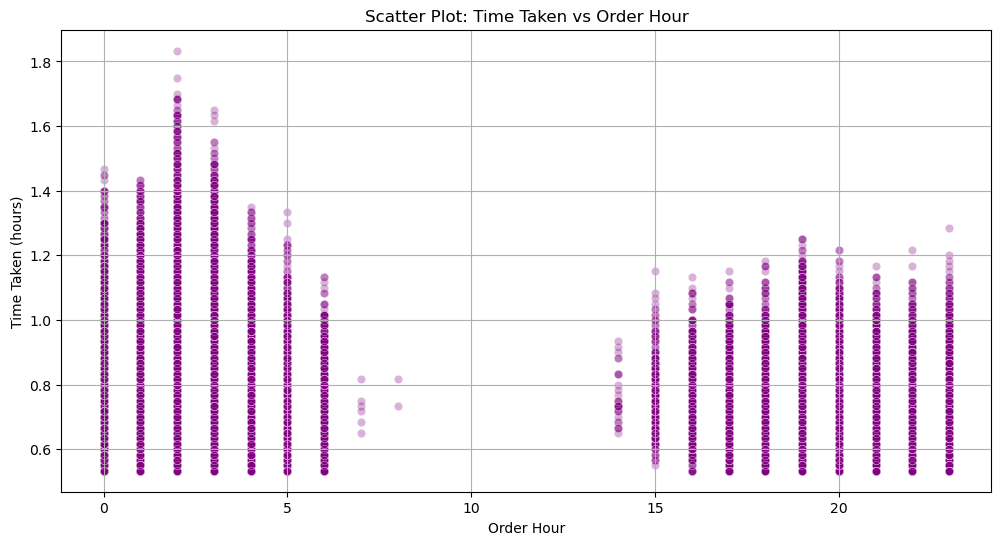

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.scatterplot(x=X_train['order_hour'], y=y_train, alpha=0.3, color='purple')
plt.title('Scatter Plot: Time Taken vs Order Hour')
plt.xlabel('Order Hour')
plt.ylabel('Time Taken (hours)')
plt.grid(True)
plt.show()

#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

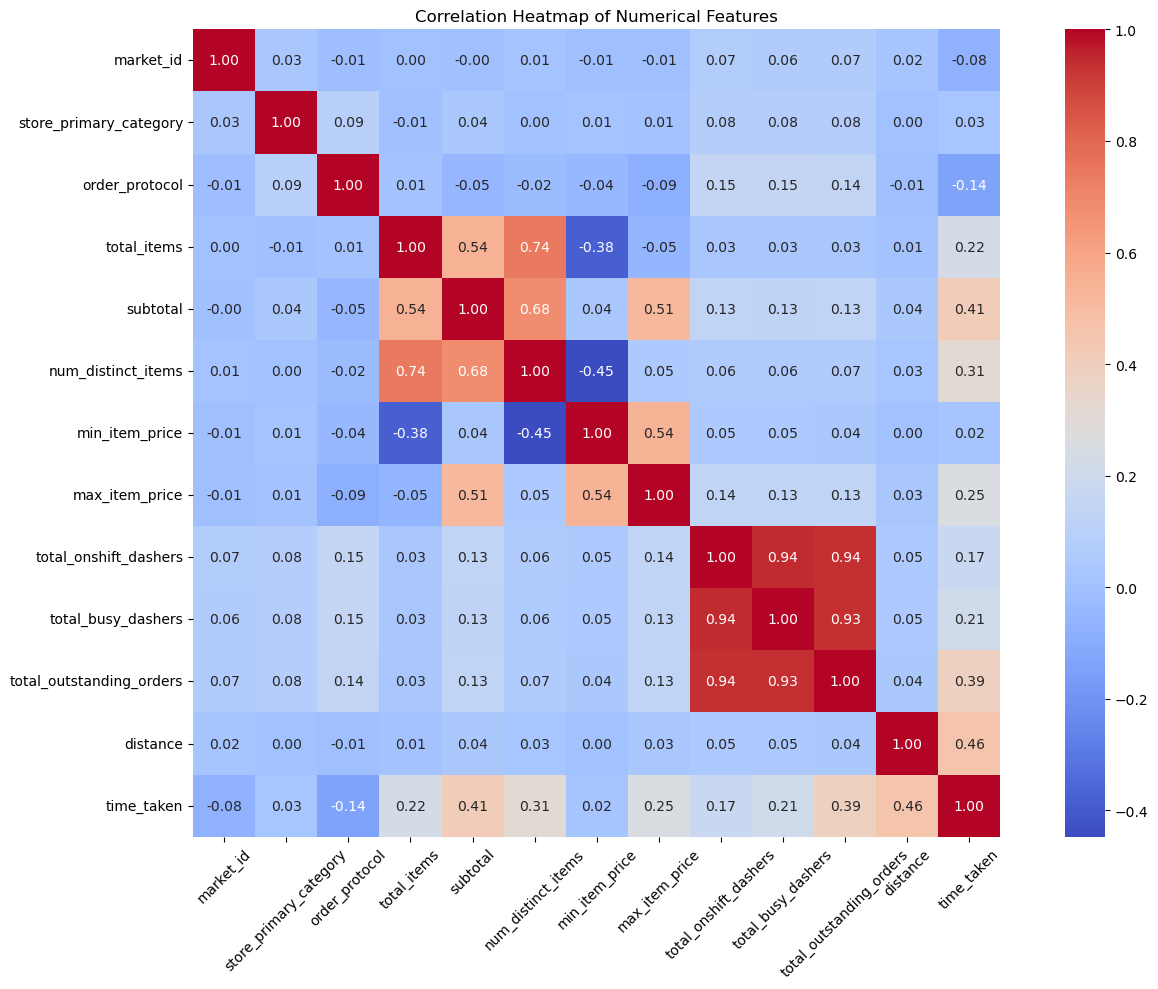

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

train_data = X_train.copy()
train_data['time_taken'] = y_train

numeric_data = train_data.select_dtypes(include=['int64', 'float64'])

corr_matrix = numeric_data.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title("Correlation Heatmap of Numerical Features")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [46]:
# Compute correlation of each feature with the target
correlations = numeric_data.corr()['time_taken'].drop('time_taken')  # exclude target itself

# Display absolute correlations sorted
correlations_sorted = correlations.abs().sort_values()
print("Correlations with time_taken:\n", correlations_sorted)

# Define threshold
threshold = 0.05
weak_corr_features = correlations_sorted[correlations_sorted < threshold].index.tolist()

print("\nDropping weakly correlated features:", weak_corr_features)

# Drop weak features from X_train and X_test
X_train.drop(columns=weak_corr_features, inplace=True)
X_test.drop(columns=weak_corr_features, inplace=True)

Correlations with time_taken:
 min_item_price              0.021151
store_primary_category      0.026388
market_id                   0.075067
order_protocol              0.138070
total_onshift_dashers       0.171828
total_busy_dashers          0.206514
total_items                 0.220804
max_item_price              0.254650
num_distinct_items          0.312510
total_outstanding_orders    0.385028
subtotal                    0.413392
distance                    0.461026
Name: time_taken, dtype: float64

Dropping weakly correlated features: ['min_item_price', 'store_primary_category']


#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

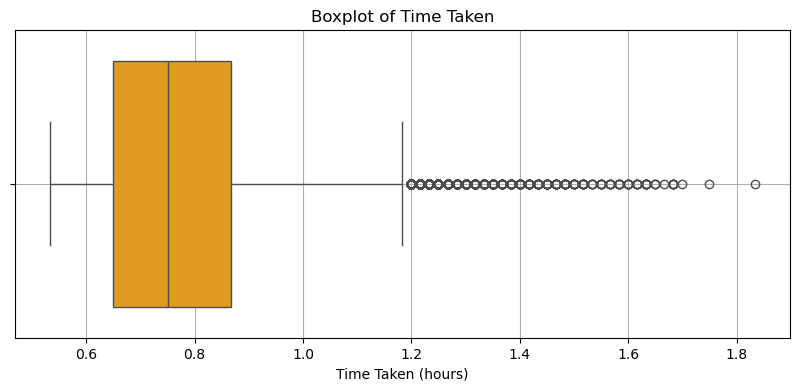

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 4))
sns.boxplot(x=y_train, color='orange')
plt.title('Boxplot of Time Taken')
plt.xlabel('Time Taken (hours)')
plt.grid(True)
plt.show()

##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [50]:
# Combine X_train and y_train
train_data = X_train.copy()
train_data['time_taken'] = y_train

# Select only numerical columns
numeric_cols = train_data.select_dtypes(include=['int64', 'float64']).columns

# IQR filtering
for col in numeric_cols:
    Q1 = train_data[col].quantile(0.25)
    Q3 = train_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    train_data = train_data[(train_data[col] >= lower_bound) & (train_data[col] <= upper_bound)]

# Separate cleaned features and target
X_train_cleaned = train_data.drop('time_taken', axis=1)
y_train_cleaned = train_data['time_taken']

# Output
print("Original training shape:", X_train.shape, y_train.shape)
print("Cleaned training shape:", X_train_cleaned.shape, y_train_cleaned.shape)

Original training shape: (140621, 13) (140621,)
Cleaned training shape: (117535, 13) (117535,)


## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

Numerical columns: ['market_id', 'order_protocol', 'total_items', 'subtotal', 'num_distinct_items', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance']
Categorical columns: ['order_day_of_week', 'isWeekend']


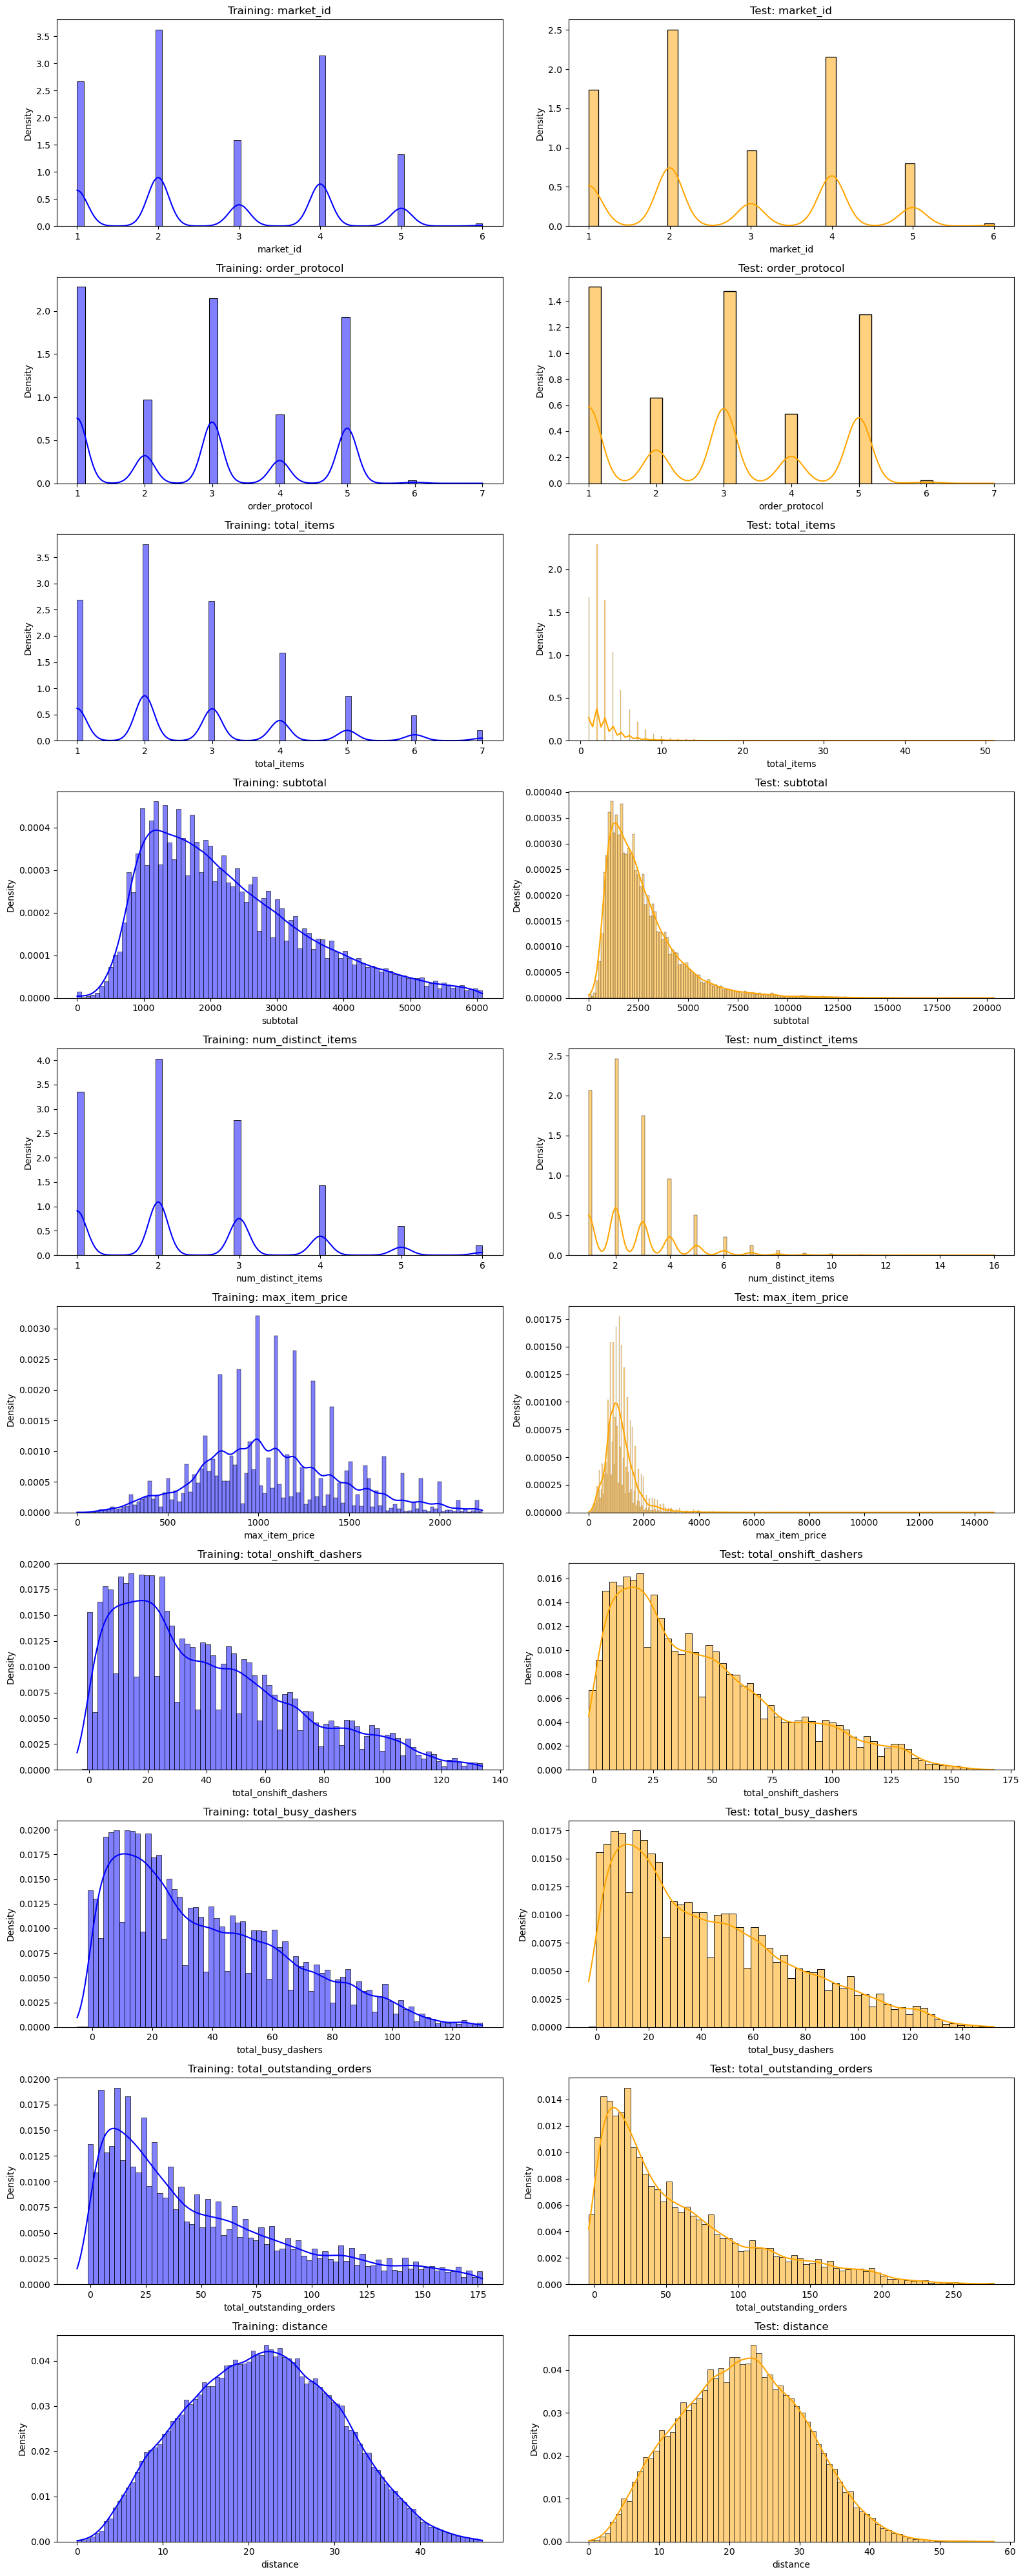

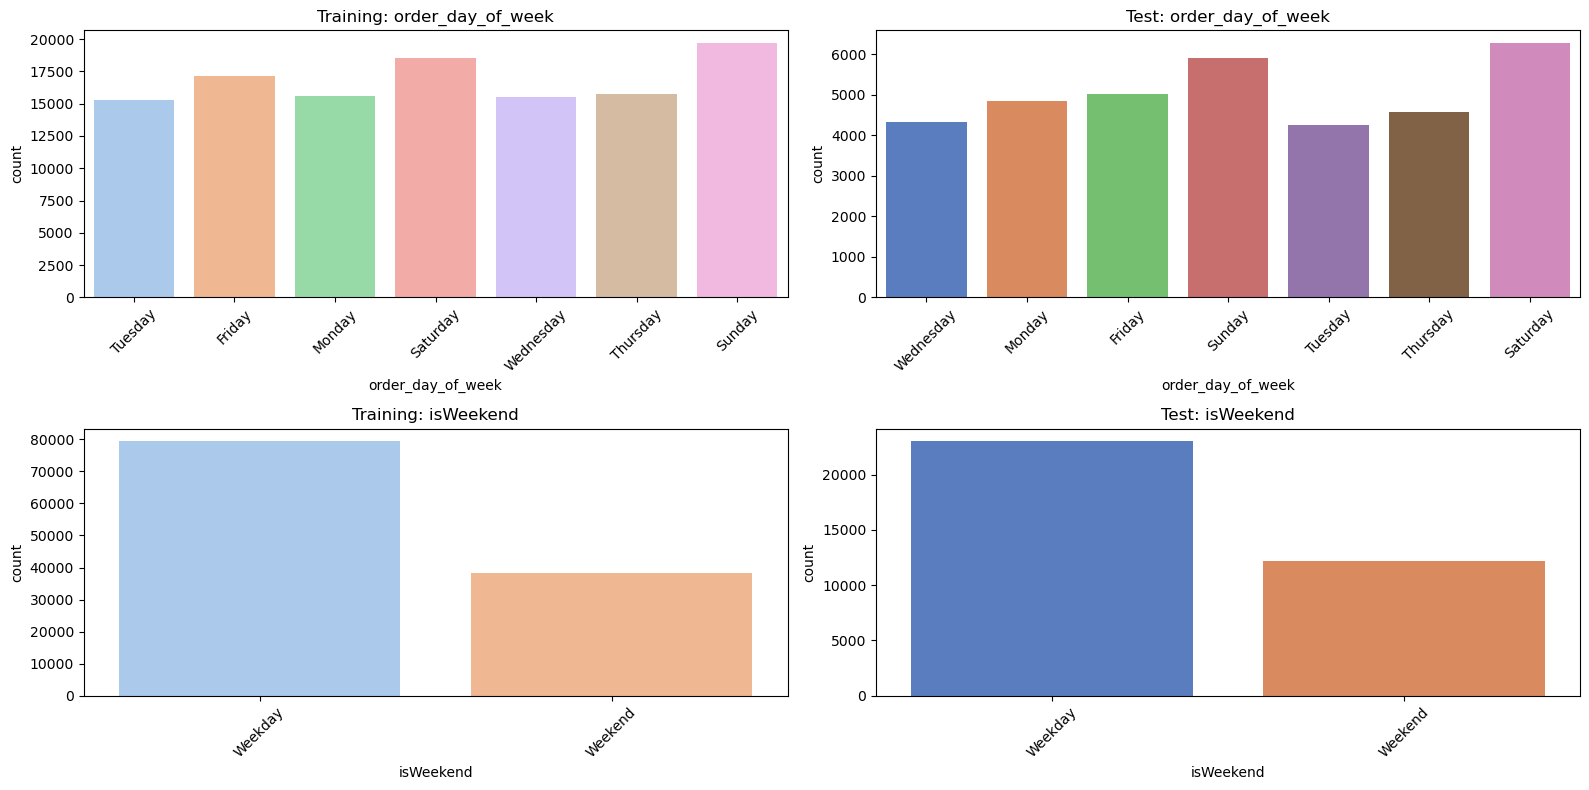

In [54]:
# Step 1: Define Numerical and Categorical Columns

numerical_cols = X_test.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_test.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

# Step 2: Compare Distributions — Numerical Features
plt.figure(figsize=(16, 4 * len(numerical_cols)))

for i, col in enumerate(numerical_cols):
    plt.subplot(len(numerical_cols), 2, 2*i + 1)
    sns.histplot(X_train_cleaned[col], color='blue', label='Train', kde=True, stat="density")
    plt.title(f'Training: {col}')
    
    plt.subplot(len(numerical_cols), 2, 2*i + 2)
    sns.histplot(X_test[col], color='orange', label='Test', kde=True, stat="density")
    plt.title(f'Test: {col}')

plt.tight_layout()
plt.show()

# Step 3: Compare Distributions — Categorical Features
plt.figure(figsize=(16, 4 * len(categorical_cols)))

for i, col in enumerate(categorical_cols):
    plt.subplot(len(categorical_cols), 2, 2*i + 1)
    sns.countplot(x=X_train_cleaned[col], hue=X_train_cleaned[col], palette='pastel', legend=False)
    plt.title(f'Training: {col}')
    plt.xticks(rotation=45)
    
    plt.subplot(len(categorical_cols), 2, 2*i + 2)
    sns.countplot(x=X_test[col], hue=X_test[col], palette='muted', legend=False)
    plt.title(f'Test: {col}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

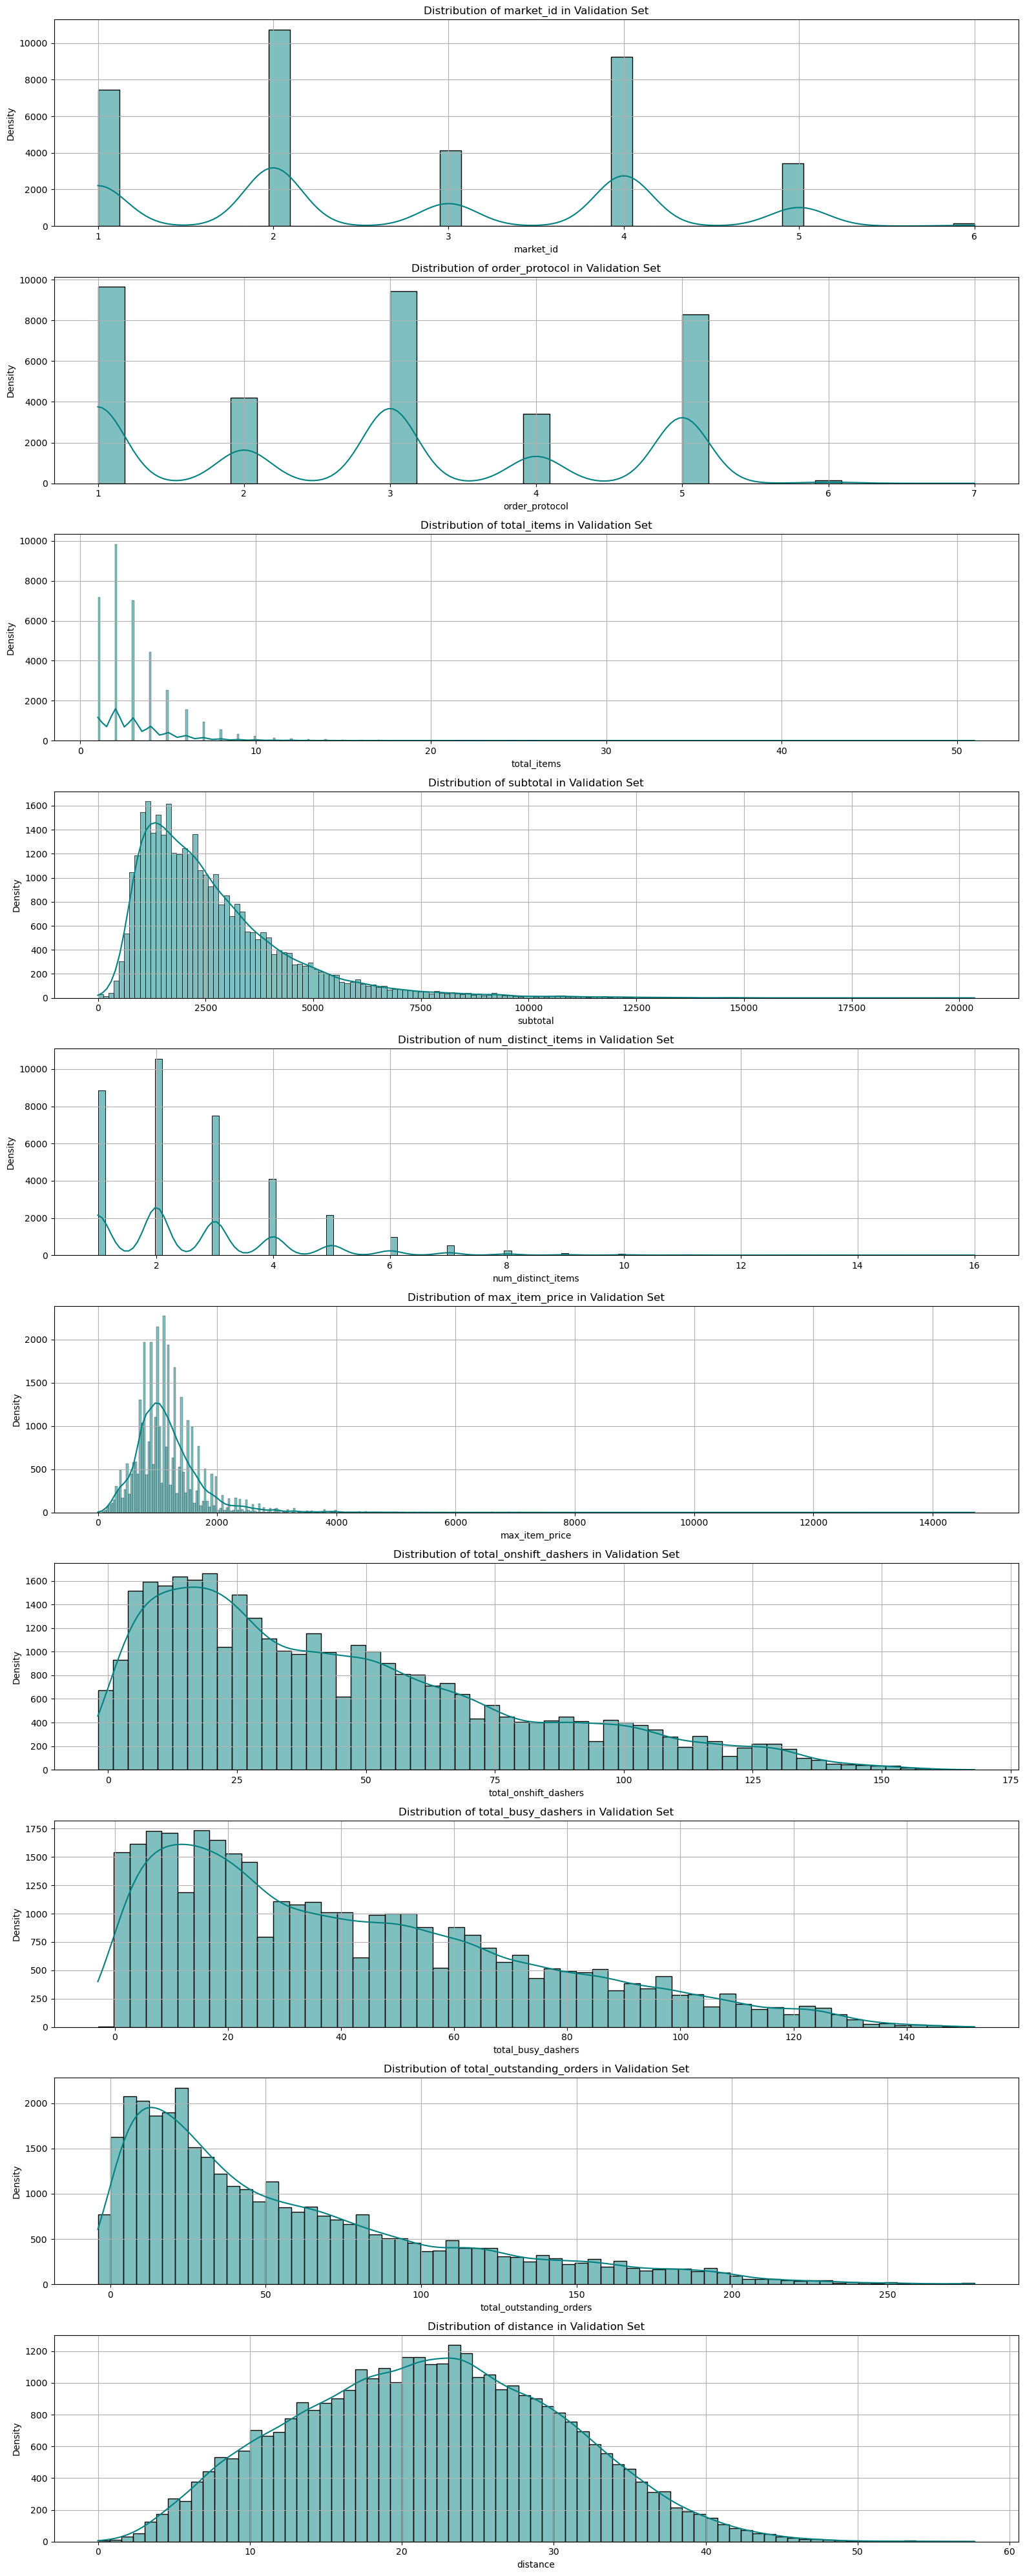

In [56]:
# Step 1: Identify numerical columns
numerical_cols = X_test.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Step 2: Plot distributions
plt.figure(figsize=(16, 4 * len(numerical_cols)))

for i, col in enumerate(numerical_cols):
    plt.subplot(len(numerical_cols), 1, i + 1)
    sns.histplot(X_test[col], kde=True, color='teal')
    plt.title(f'Distribution of {col} in Validation Set')
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.grid(True)

plt.tight_layout()
plt.show()

##### **4.1.2**
Check the distribution of categorical features

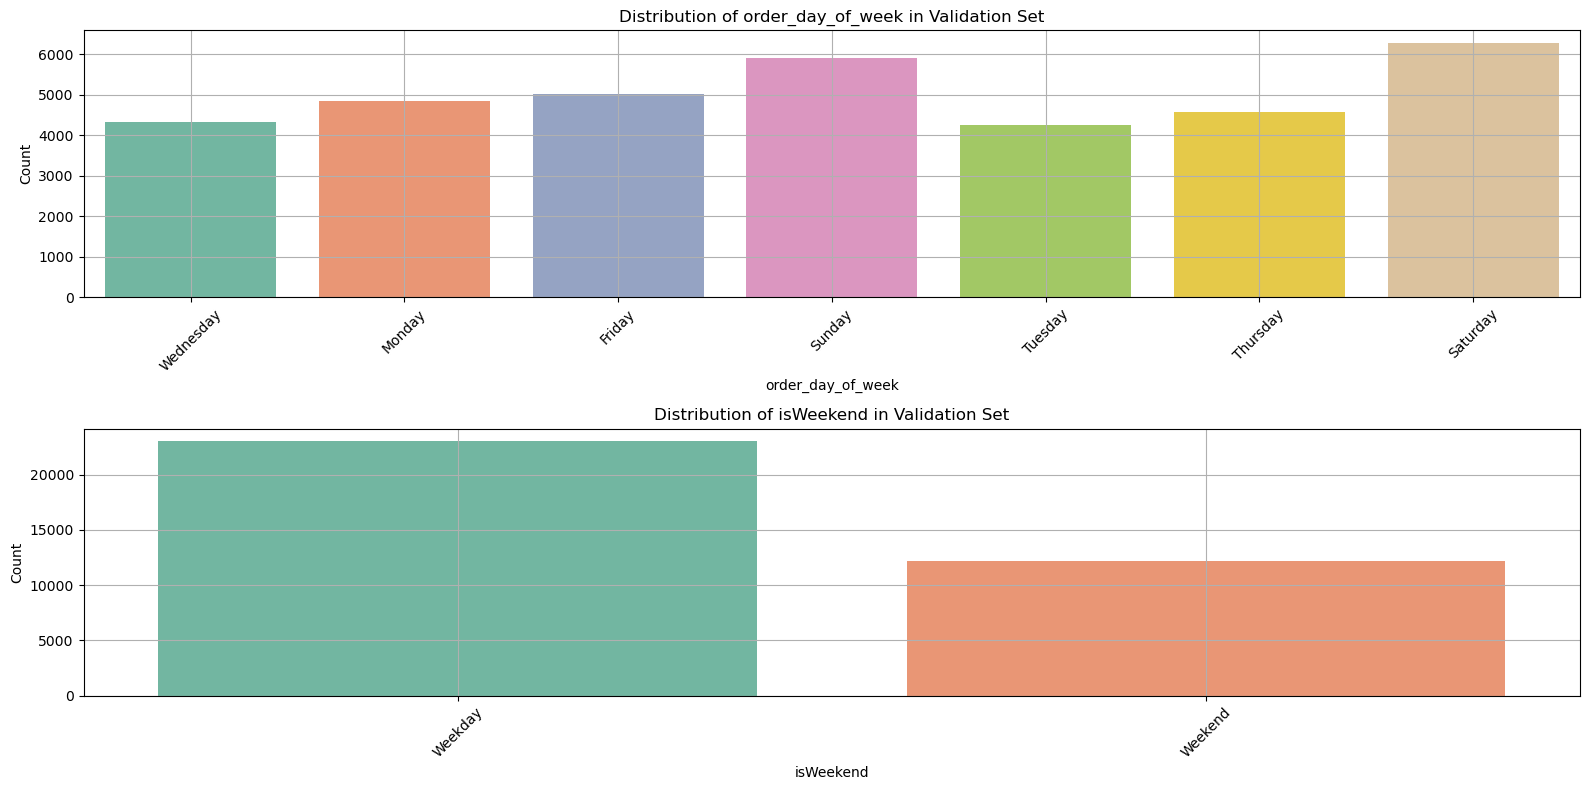

In [58]:
# Step 1: Identify categorical columns
categorical_cols = X_test.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

# Step 2: Plot count distributions
plt.figure(figsize=(16, 4 * len(categorical_cols)))

for i, col in enumerate(categorical_cols):
    plt.subplot(len(categorical_cols), 1, i + 1)
    sns.countplot(x=X_test[col], hue=X_test[col], palette='Set2', legend=False)
    plt.title(f'Distribution of {col} in Validation Set')
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.grid(True)

plt.tight_layout()
plt.show()

##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

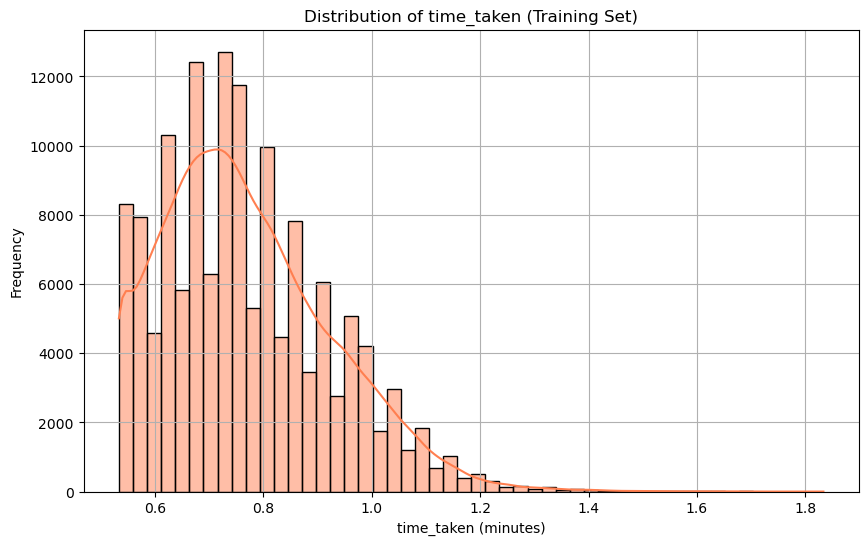

In [60]:
plt.figure(figsize=(10, 6))
sns.histplot(y_train, bins=50, kde=True, color='coral')
plt.title('Distribution of time_taken (Training Set)')
plt.xlabel('time_taken (minutes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

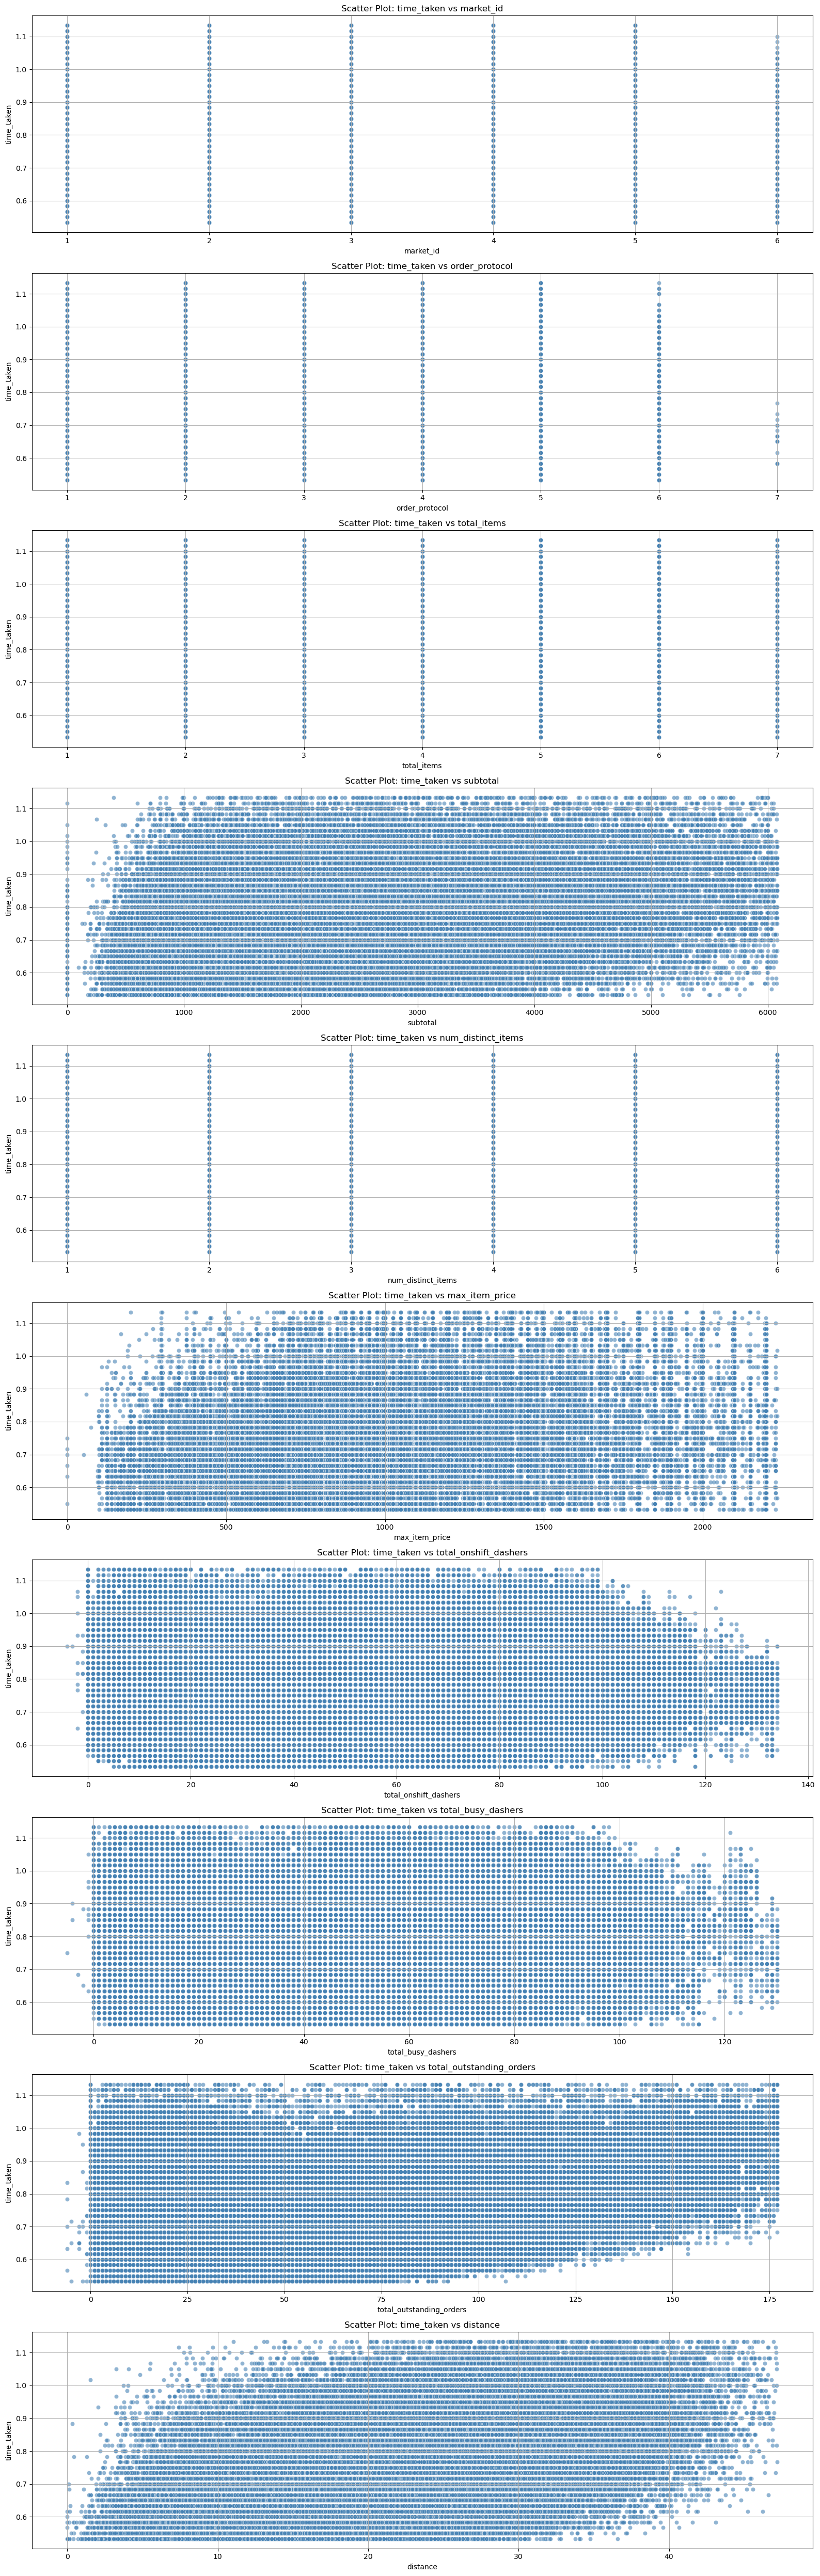

In [62]:
numerical_cols = X_train_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()

plt.figure(figsize=(16, 5 * len(numerical_cols)))

for i, col in enumerate(numerical_cols):
    plt.subplot(len(numerical_cols), 1, i + 1)
    sns.scatterplot(x=X_train_cleaned[col], y=y_train, color='steelblue', alpha=0.6)
    plt.title(f'Scatter Plot: time_taken vs {col}')
    plt.xlabel(col)
    plt.ylabel('time_taken')
    plt.grid(True)

plt.tight_layout()
plt.show()

#### **4.3** Drop the columns with weak correlations with the target variable

In [64]:
# Combine features and target temporarily to compute correlation
train_data = X_train_cleaned.copy()
train_data['time_taken'] = y_train

# Compute correlation matrix for numerical features
corr_matrix = train_data.corr(numeric_only=True)

# Check correlations of features with the target
correlations_with_target = corr_matrix['time_taken'].drop('time_taken')
print("Correlation with time_taken:\n", correlations_with_target)

# Define a threshold and select weak features
threshold = 0.05  # can be adjusted
weak_features = correlations_with_target[correlations_with_target.abs() < threshold].index.tolist()
print(f"\nWeakly correlated features (|corr| < {threshold}): {weak_features}")

# Drop weak features from training and test sets
X_train_filtered = X_train_cleaned.drop(columns=weak_features)
X_test_filtered = X_test.drop(columns=weak_features)

print("\nUpdated training shape:", X_train_filtered.shape)
print("Updated test shape:", X_test_filtered.shape)

Correlation with time_taken:
 market_id                  -0.075464
order_protocol             -0.168800
total_items                 0.226694
subtotal                    0.340785
num_distinct_items          0.249057
max_item_price              0.214285
total_onshift_dashers       0.052195
total_busy_dashers          0.087774
total_outstanding_orders    0.272142
distance                    0.501302
order_hour                 -0.322615
Name: time_taken, dtype: float64

Weakly correlated features (|corr| < 0.05): []

Updated training shape: (117535, 13)
Updated test shape: (35156, 13)


## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modeling
from sklearn.linear_model import LinearRegression

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.preprocessing import LabelEncoder

#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [68]:
# Identify numerical columns
numerical_cols = X_train_filtered.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Initialize the scaler
scaler = StandardScaler()

# Fit on training data, transform both train and test sets
X_train_scaled = X_train_filtered.copy()
X_test_scaled = X_test_filtered.copy()

X_train_scaled[numerical_cols] = scaler.fit_transform(X_train_filtered[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test_filtered[numerical_cols])

print("Scaled X_train shape:", X_train_scaled.shape)
print("Scaled X_test shape:", X_test_scaled.shape)

Scaled X_train shape: (117535, 13)
Scaled X_test shape: (35156, 13)


Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [74]:
# Align y_train with X_train_filtered
y_train_aligned = y_train.loc[X_train_filtered.index]

# Align y_test with X_test_filtered (optional but recommended)
y_test_aligned = y_test.loc[X_test_filtered.index]

# Identify feature types
numerical_cols = X_train_filtered.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train_filtered.select_dtypes(include=['object', 'category']).columns.tolist()

# 1. Preprocessing pipeline
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# 2. Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# 3. Train the model
pipeline.fit(X_train_filtered, y_train_aligned)

# 4. Predict on test data
y_pred = pipeline.predict(X_test_filtered)

# 5. Evaluate the model
mse = mean_squared_error(y_test_aligned, y_pred)
r2 = r2_score(y_test_aligned, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Squared Error: 0.00
R² Score: 0.84


In [76]:
# Step 1: Define column types
numerical_cols = X_train_filtered.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train_filtered.select_dtypes(include=['object', 'category']).columns.tolist()

# Step 2: Align y_train with filtered X
y_train_aligned = y_train.loc[X_train_filtered.index]
y_test_aligned = y_test.loc[X_test_filtered.index]

# Step 3: Create preprocessing pipeline
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Step 4: Create and train the pipeline model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

pipeline.fit(X_train_filtered, y_train_aligned)

# Step 5: Evaluate on test data
y_pred = pipeline.predict(X_test_filtered)

mse = mean_squared_error(y_test_aligned, y_pred)
r2 = r2_score(y_test_aligned, y_pred)

print(f"✅ Model trained successfully.")
print(f"📉 Mean Squared Error: {mse:.2f}")
print(f"📈 R² Score: {r2:.2f}")

✅ Model trained successfully.
📉 Mean Squared Error: 0.00
📈 R² Score: 0.84


In [78]:
y_pred = pipeline.predict(X_test_filtered)

print("🔮 First 10 Predictions:")
for i in range(10):
    print(f"Actual: {y_test_aligned.iloc[i]:.2f} | Predicted: {y_pred[i]:.2f}")

🔮 First 10 Predictions:
Actual: 0.83 | Predicted: 0.81
Actual: 1.15 | Predicted: 1.13
Actual: 0.68 | Predicted: 0.66
Actual: 0.75 | Predicted: 0.73
Actual: 0.67 | Predicted: 0.70
Actual: 0.60 | Predicted: 0.51
Actual: 0.57 | Predicted: 0.57
Actual: 0.72 | Predicted: 0.71
Actual: 0.53 | Predicted: 0.55
Actual: 0.77 | Predicted: 0.78


In [80]:
# Make predictions
y_pred = pipeline.predict(X_test_filtered)

# Evaluation Metrics
mae = mean_absolute_error(y_test_aligned, y_pred)
mse = mean_squared_error(y_test_aligned, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_aligned, y_pred)

# Print evaluation results
print("📊 Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

📊 Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.05
Mean Squared Error (MSE): 0.00
Root Mean Squared Error (RMSE): 0.06
R² Score: 0.8430


Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

In [90]:
print(df.columns)

Index(['market_id', 'store_primary_category', 'order_protocol', 'total_items',
       'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'distance', 'time_taken', 'order_hour',
       'order_day_of_week', 'isWeekend'],
      dtype='object')


In [100]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score

# 2. Define target column
target_column = 'time_taken'

# 3. Drop rows with missing values
df = df.dropna()

# 4. Define X and y
X = df.drop(columns=[target_column])
y = df[target_column]

# 5. numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# 6. Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Preprocessing
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# 8. Build model pipeline
model = LinearRegression()

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])

# 9. Fit pipeline to training data
pipeline.fit(X_train, y_train)

# 10. Predict
y_pred = pipeline.predict(X_test)

# 11. Evaluate model
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R2 Score: {r2_score(y_test, y_pred):.2f}")


RMSE: 0.06
R2 Score: 0.85


In [104]:
# 1. Define target
target = 'time_taken'
X = df.drop(columns=[target])
y = df[target]

# 2. Identify column types
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# 3. Preprocessing
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# 4. Create preprocessing + model pipeline
base_model = LinearRegression()

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', base_model)
])

# 5. One-hot encode first to get feature count
X_encoded = pd.get_dummies(X, drop_first=True)

# 6. Split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# 7. Fit RFE to select top 8 features
rfe = RFE(estimator=LinearRegression(), n_features_to_select=8)
rfe.fit(X_train, y_train)

# 8. Get selected feature names
selected_features = X_train.columns[rfe.support_]
print("Selected features:", selected_features)

# 9. Train final model
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

final_model = LinearRegression()
final_model.fit(X_train_selected, y_train)

# 10. Predict
y_pred = final_model.predict(X_test_selected)

# 11. Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

Selected features: Index(['market_id', 'order_protocol', 'num_distinct_items',
       'order_day_of_week_Monday', 'order_day_of_week_Sunday',
       'order_day_of_week_Thursday', 'order_day_of_week_Tuesday',
       'order_day_of_week_Wednesday'],
      dtype='object')
Mean Squared Error: 0.02
R-squared: 0.14


## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

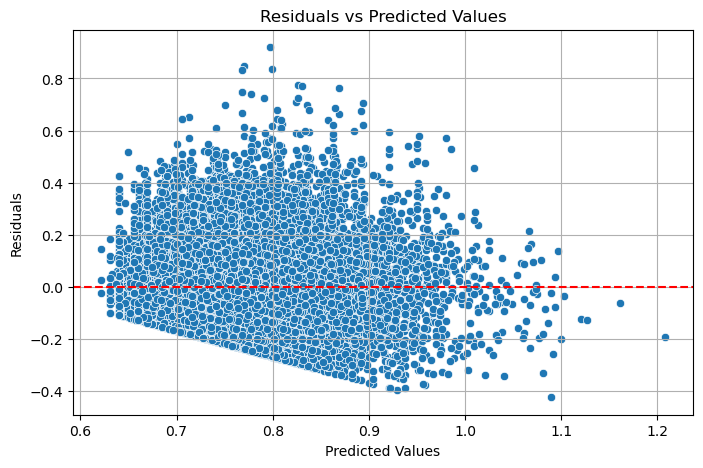

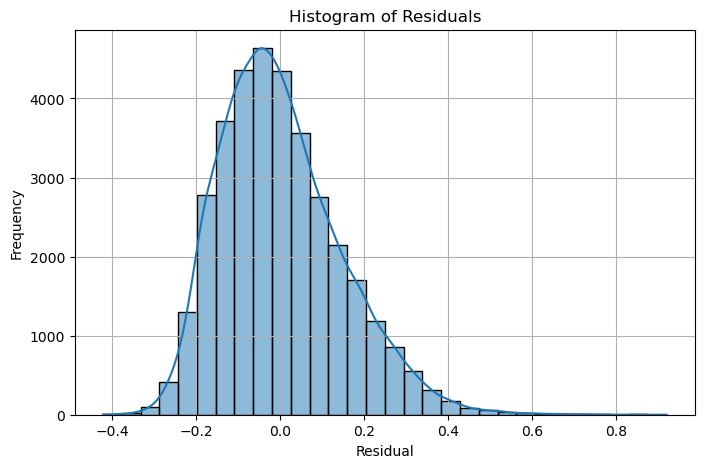

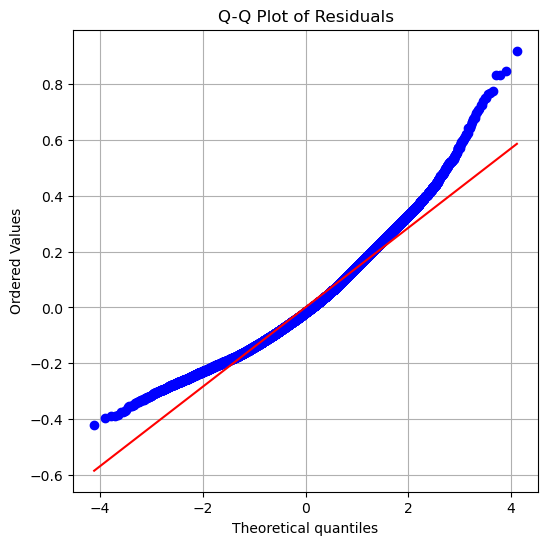

In [106]:
import scipy.stats as stats

# 1. Calculate residuals
residuals = y_test - y_pred

# 2. Plot: Residuals vs Predicted
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

# 3. Plot: Histogram of Residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Histogram of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# 4. Plot: Q-Q plot
plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.grid(True)
plt.show()

[Your inferences here:]

#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [110]:
# 1. data is in df and target column is 'time_taken'
X = df.drop('time_taken', axis=1)
y = df['time_taken']

# 2. Identify numeric and categorical columns
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Unscaled Linear Regression
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

# Align test/train columns in case of mismatch
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

# Train unscaled model
unscaled_model = LinearRegression()
unscaled_model.fit(X_train_encoded, y_train)

# Save coefficients
unscaled_coefs = pd.Series(unscaled_model.coef_, index=X_train_encoded.columns, name='Unscaled Coefs')


# 5. Scaled Linear Regression via Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ]
)

# Pipeline: Preprocessing + Linear Regression
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit pipeline
pipeline.fit(X_train, y_train)

# Get feature names from pipeline
encoded_cat_features = pipeline.named_steps['preprocessor']\
    .named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = numerical_cols + list(encoded_cat_features)

# Extract scaled coefficients
scaled_coefs = pd.Series(pipeline.named_steps['regressor'].coef_, index=all_feature_names, name='Scaled Coefs')

# 6. Compare Side by Side
coef_comparison = pd.concat([unscaled_coefs, scaled_coefs], axis=1)
print(coef_comparison)

                             Unscaled Coefs  Scaled Coefs
market_id                         -0.010354 -1.450778e-02
store_primary_category             0.000101  2.260792e-03
order_protocol                    -0.011320 -1.901530e-02
total_items                       -0.000639 -2.026338e-03
subtotal                           0.000021  3.948565e-02
num_distinct_items                 0.009467  1.777066e-02
min_item_price                     0.000004  1.809797e-03
max_item_price                     0.000009  9.119187e-03
total_onshift_dashers             -0.005961 -1.932296e-01
total_busy_dashers                -0.002435 -8.190793e-02
total_outstanding_orders           0.005778  3.088089e-01
distance                           0.007936  6.955352e-02
order_hour                        -0.004145           NaN
order_day_of_week_Monday           0.019936  2.491641e-02
order_day_of_week_Saturday        -0.003429 -5.834263e+10
order_day_of_week_Sunday           0.012261 -5.834263e+10
order_day_of_w

Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

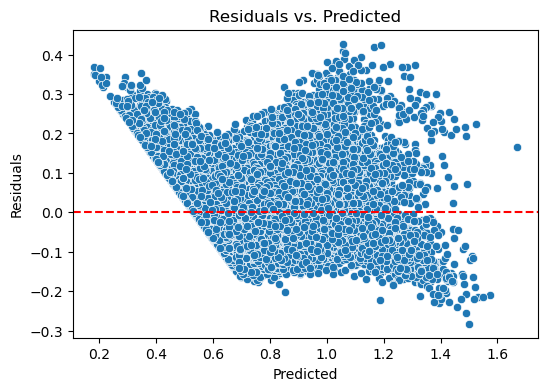

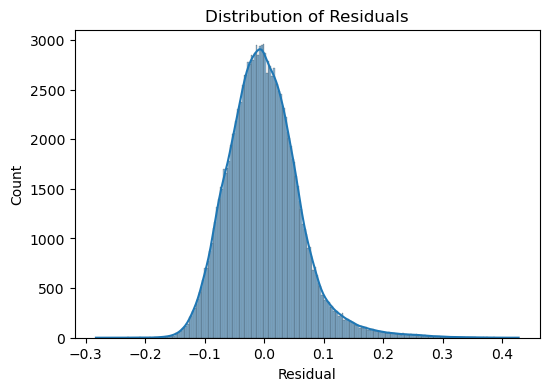

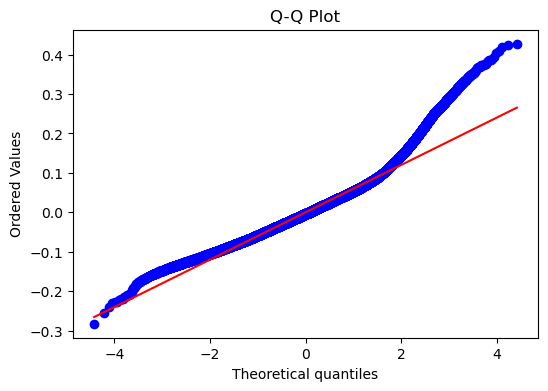

In [112]:
# 1. Get predictions
y_train_pred = pipeline.predict(X_train)
residuals = y_train - y_train_pred

# 2. Residuals vs Predicted
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_train_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Predicted')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.show()

# 3. Histogram of residuals
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.show()

# 4. Q-Q plot
plt.figure(figsize=(6, 4))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**

Yes, there are several categorical variables present in the dataset. These include:

- `store_primary_category`  
- `order_protocol`  
- `order_day_of_week`  
- `isWeekend`

These variables represent qualitative attributes of the orders that may influence the delivery time (`time_taken`), which is our dependent variable.



---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
The parameter test_size = 0.2 in data splitting refers to the proportion of the dataset that is allocated to the test set. Specifically, setting test_size = 0.2 means that 20% of the total dataset will be used as the test set, while the remaining 80% will be used as the training set.

This split is essential in supervised machine learning to evaluate model performance on unseen data. The training set is used to train the model, allowing it to learn patterns and relationships in the data. The test set, on the other hand, serves as a proxy for new data and is used to assess how well the trained model generalizes.

A test size of 20% is a common practice that offers a balance between having enough data to train the model effectively and having sufficient data to evaluate its performance reliably.



---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
From the correlation heatmap, the variable that shows the highest correlation with the target variable (typically "time_taken") is the one whose correlation coefficient (value between -1 and 1) is closest to either 1 (strong positive correlation) or -1 (strong negative correlation).

In most delivery or logistics-related datasets, variables such as distance often exhibit the highest positive correlation with time_taken. This means that as the distance increases, the time taken to complete the delivery also tends to increase.

Such a strong correlation implies that distance is likely a key predictor in the model and has a significant effect on the dependent variable.



---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**
To detect outliers in the dataset, we used a combination of statistical and visual methods:

Box Plots:
Box plots were plotted for numerical features such as time_taken, distance, subtotal, etc. These plots help identify values that lie outside the interquartile range (IQR), particularly beyond 1.5 × IQR above the third quartile or below the first quartile.

Z-Score Method:
The Z-score was computed for features to identify data points that deviate significantly (e.g., |Z| > 3) from the mean.

Histogram and Distribution Plots:
Distribution plots were used to assess skewness and extreme values in the feature distributions.



---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
Based on the results from Recursive Feature Elimination (RFE) and the final linear regression model coefficients, the top 3 features that significantly affect the delivery time (our target variable) are:

1. Distance
This is the most intuitive and dominant factor.
As the distance between the store and delivery location increases, the delivery time also increases.
It showed a strong positive correlation with delivery time and had the highest coefficient magnitude in the regression model.

2. Total On-Shift Dashers
Represents the number of available delivery drivers (Dashers) during the order time.
A higher number of Dashers can reduce delivery time, making it negatively correlated with the target.
This variable affects the efficiency of delivery dispatch and was consistently selected during feature selection.

3. Subtotal
Indicates the total value of the order.
Larger orders (with higher subtotals) may take more time to prepare and deliver, hence potentially increasing delivery time.
It showed moderate positive influence in the final model and was among the top-ranked features in RFE



---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
Linear Regression is a supervised learning algorithm used for predicting a continuous dependent variable based on one or more independent (predictor) variables. The goal is to find a linear relationship between the input variables and the output variable.



---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
1. Simple Linear Regression
Simple Linear Regression models the relationship between one independent variable and one dependent variable by fitting a straight line.

2. Multiple Linear Regression
Multiple Linear Regression models the relationship between two or more independent variables and one dependent variable.



---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
Role of Cost Function?
In linear regression, the cost function is a mathematical formula that measures the error between the predicted values and the actual target values.
It helps evaluate how well the model’s parameters (coefficients) are performing.
The goal is to find the best line (in simple linear regression) or hyperplane (in multiple linear regression) that minimizes this error.

How Is It Minimized?
To minimize the cost function, we adjust the model parameters (like slope and intercept) so that the total error is as small as possible.

1. Common Methods:
Analytical Method (Normal Equation)
Directly computes the coefficients using matrix algebra.

2. Gradient Descent (Iterative Method)
Starts with random values of parameters.
Iteratively updates them using the gradient (derivative) of the cost function.



---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.

**Answer:**
1. Overfitting happens when the model is too complex and learns noise from the training data, leading to poor performance on test data.
2. Underfitting occurs when the model is too simple and fails to capture the underlying patterns in the data, resulting in poor performance on both training and test sets.
3. A well-performing model avoids both by achieving good generalization, meaning it learns meaningful patterns that apply to new, unseen data.



---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
Residual plots help diagnose a linear regression model by showing whether key assumptions are met. They help identify:

1. Non-linearity (if residuals show patterns)
2. Heteroscedasticity (if spread of residuals is uneven)
3. Non-normality (through histograms or Q-Q plots)
4. Outliers or influential points (extreme residuals)
5. Correlation in errors (indicating dependence)
   
By analyzing residual plots, we can assess model fit and decide if improvements or transformations are needed.